In [129]:
# importing libraries
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import seaborn as sns 
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing import image

## undestanding the data

In [130]:
# let us know about the classes in the data
path= 'Dataset/CNN/Shoe Classification/train'
class_names = sorted(os.listdir(path))
class_names

['Boots', 'Sandals', 'Slippers']

In [131]:
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

train_folder = "Dataset/CNN/Shoe Classification/train"

# Function to load images and their labels
def load_data(folder):
    images = []
    labels = []
    for category in os.listdir(folder):
        category_folder = os.path.join(folder, category)
        if os.path.isdir(category_folder):
            for filename in os.listdir(category_folder):
                img_path = os.path.join(category_folder, filename)
                img = Image.open(img_path)
                images.append(img)
                labels.append(category)
    return images, labels

# Load images and labels from the train dataset
img_train, img_labels = load_data(train_folder)

# creating a dataframe of images and their labels
train_df = pd.DataFrame({"image": train_images, "label": train_labels})
train_distribution = train_df["label"].value_counts()

# Display distribution of training data
print("Distribution of training data:")
print(train_distribution)


Distribution of training data:
Boots       262
Sandals     245
Slippers    115
Name: label, dtype: int64


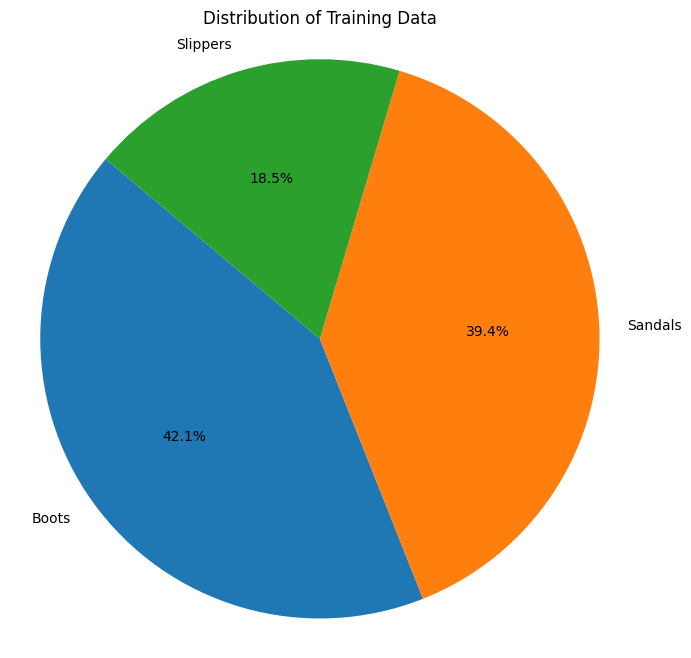

In [132]:
# lets plot the data distribution
plt.figure(figsize=(8, 8))
plt.pie(train_distribution, labels=train_distribution.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Training Data')
plt.show()

In [133]:
# Initialize Generator
gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    rotation_range=20,
    validation_split=0.2
)

# Load Data
train_ds = gen.flow_from_directory(
    path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="training"
)
valid_ds = gen.flow_from_directory(
    path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
    subset="validation"
)

# Load and preprocess test data
test_dir='Dataset/CNN/Shoe Classification/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
        test_dir,  # directory for test images
        batch_size=32,
        target_size=(256,256),
        class_mode='categorical',
        )

Found 623 images belonging to 3 classes.
Found 155 images belonging to 3 classes.
Found 0 images belonging to 0 classes.


## Data vizualisation

In [134]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

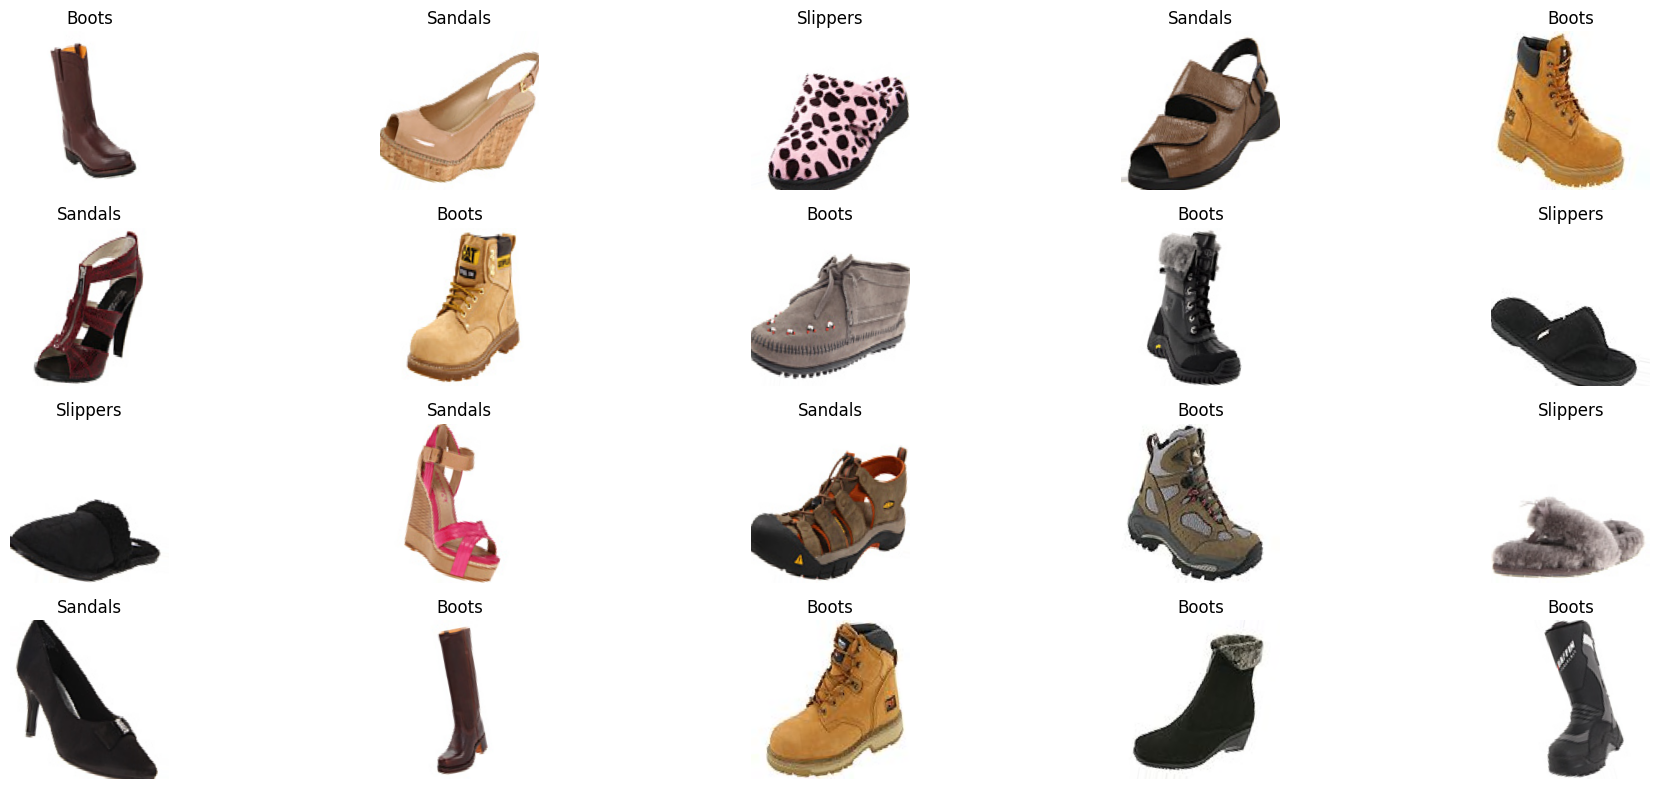

In [135]:
i=1
plt.figure(figsize=(20,8))
for images, labels in train_ds:
    index = np.random.randint(len(images))
    image, label = images[index], labels[index]

    plt.subplot(4,5, i)
    show_image(image, title=f"{class_names[int(label)]}")
    i+=1
    if i>=21: break

plt.tight_layout()
plt.show()

## Building CNN model

In [142]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.initializers import he_normal
cnn= Sequential([  
      
    # First Convolution Layer 
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal(), input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2),padding='same'),
    BatchNormalization(),
    
    # Second Convolution Layer
    Conv2D(32, kernel_size=(3, 3), padding='same',  kernel_initializer=he_normal(),activation='relu'),
    MaxPooling2D(pool_size=(2, 2),padding='same'),
    BatchNormalization(),
    # Drop Out 
    Dropout(0.40),
    
    # 3 Convolution Layer
    Conv2D(32, kernel_size=(3, 3), padding='same',  kernel_initializer=he_normal(),activation='relu', name='CONV_Layer3'),
    MaxPooling2D(pool_size=(2, 2),padding='same'),
    BatchNormalization(),
    # Drop Out 
    Dropout(0.40),

    # Flatten
    Flatten(input_shape=(256, 256, 3)),
    # Fully Connected Layer
    Dense(220, activation='relu', kernel_initializer=he_normal(), name='FullyConnected1'),
    Dense(64,activation="relu"),
    Dense(40,activation="relu"),
    # Output Layer 
    Dense(3, activation='softmax', kernel_initializer=he_normal(), name='OutputLayer')
])
cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_39 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                     

In [143]:
cnn.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])


In [144]:
from tensorflow.keras.callbacks import EarlyStopping
#fitting the model
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5, 
    restore_best_weights=True,
)

#Fitting Model
history = cnn.fit(train_ds,
                        epochs= 30,
                        steps_per_epoch = len(train_ds),
                        validation_data = valid_ds,
                        validation_steps = len(valid_ds),
                        callbacks = early_stopping)

Epoch 1/30
20/20 [==============================] - 52s 2s/step - loss: 1.0369 - accuracy: 0.6437 - val_loss: 7.6324 - val_accuracy: 0.4129
Epoch 2/30
20/20 [==============================] - 49s 2s/step - loss: 0.5414 - accuracy: 0.7913 - val_loss: 3.5670 - val_accuracy: 0.4000
Epoch 3/30
20/20 [==============================] - 52s 3s/step - loss: 0.3734 - accuracy: 0.8604 - val_loss: 0.9554 - val_accuracy: 0.5742
Epoch 4/30
20/20 [==============================] - 62s 3s/step - loss: 0.2629 - accuracy: 0.8973 - val_loss: 0.7532 - val_accuracy: 0.6452
Epoch 5/30
20/20 [==============================] - 54s 3s/step - loss: 0.2391 - accuracy: 0.9117 - val_loss: 0.9975 - val_accuracy: 0.5742
Epoch 6/30
20/20 [==============================] - 55s 3s/step - loss: 0.2223 - accuracy: 0.9069 - val_loss: 1.1577 - val_accuracy: 0.6323
Epoch 7/30
20/20 [==============================] - 53s 3s/step - loss: 0.2349 - accuracy: 0.9278 - val_loss: 1.8496 - val_accuracy: 0.4710
Epoch 8/30
20/20 [==

In [157]:
cnn.evaluate(valid_ds)

5/5 [==============================] - 3s 588ms/step - loss: 0.6476 - accuracy: 0.7290


[0.6476284861564636, 0.7290322780609131]

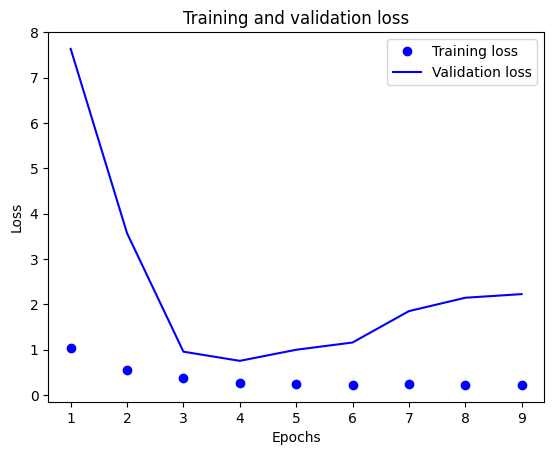

In [158]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

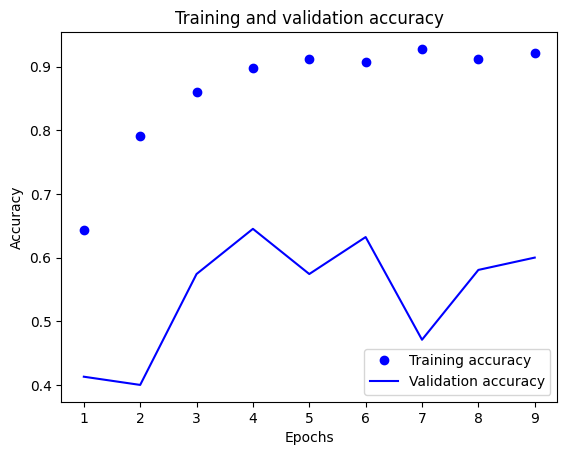

In [163]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## confusion matrix

5/5 [==============================] - 3s 577ms/step


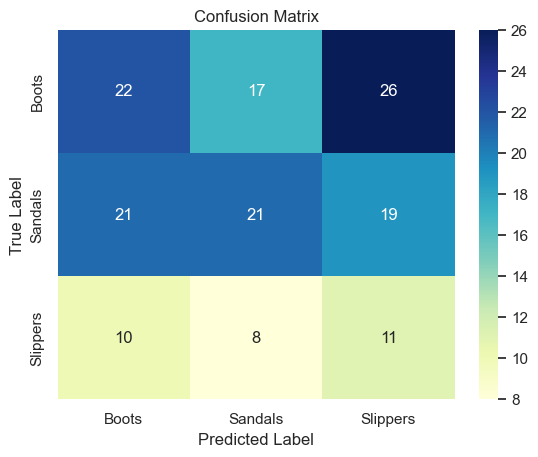

In [168]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

validation_labels = valid_ds.classes
validation_pred_probs = cnn.predict(valid_ds)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_ds.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()